In [1]:
# Install required packages
!pip install torch torchvision numpy matplotlib scikit-learn pandas tqdm

# Check GPU info
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from typing import List, Dict, Tuple
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import copy
from torch.utils.data import DataLoader, Subset
from tqdm.notebook import tqdm

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Data loading and preprocessing

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.72MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



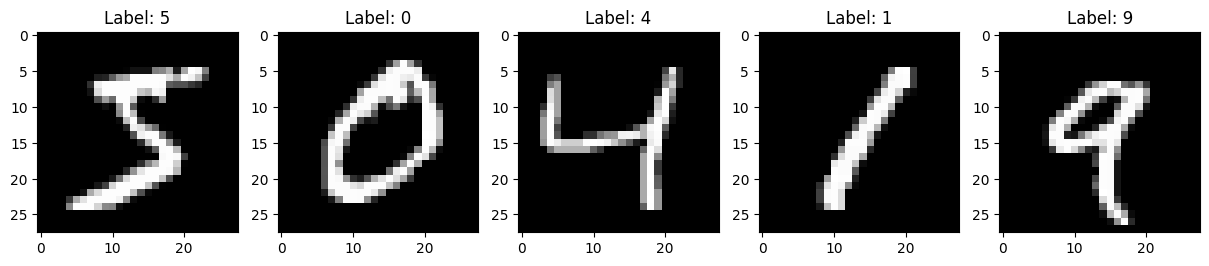

In [3]:
# Cell 2: Data loading and preprocessing
# Data transforms
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform_train)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                   download=True, transform=transform_test)
# Visualize some examples
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(trainset.data[i], cmap='gray')
    plt.title(f'Label: {trainset.targets[i]}')
plt.show()

#no need for data augmentation

In [7]:
# Cell 3: Create Non-IID Data
def create_non_iid_data(dataset, num_clients=6, alpha=0.3):
   labels = torch.tensor(dataset.targets)
   num_classes = len(dataset.classes)
   client_data_indices = [[] for _ in range(num_clients)]

   label_indices = defaultdict(list)
   for idx, label in enumerate(labels):
       label_indices[label.item()].append(idx)

   dirichlet_dist = np.random.dirichlet([alpha] * num_clients, num_classes)

   for k in range(num_classes):
       indices = label_indices[k]
       props = dirichlet_dist[k]

       client_sample_sizes = (props * len(indices)).astype(int)
       client_sample_sizes[-1] = len(indices) - client_sample_sizes[:-1].sum()

       start_idx = 0
       for client_id, size in enumerate(client_sample_sizes):
           client_indices = indices[start_idx:start_idx + size]
           client_data_indices[client_id].extend(client_indices)
           start_idx += size

   return [Subset(dataset, indices) for indices in client_data_indices]

def create_data_loaders(client_datasets, testset, batch_size=32):
   train_loaders = []
   test_loaders = []

   for dataset in client_datasets:
       train_loaders.append(DataLoader(dataset, batch_size=batch_size,
                                     shuffle=True, num_workers=2))
       test_loaders.append(DataLoader(testset, batch_size=batch_size,
                                    shuffle=False, num_workers=2))

   return train_loaders, test_loaders

In [9]:
# Cell 4: Create and Print Data Distributions
# Create client datasets
client_datasets = create_non_iid_data(trainset, num_clients=6)

# Print train distributions
print("Training Data Distributions:")
for client_id, dataset in enumerate(client_datasets):
    client_labels = [trainset.targets[idx].item() for idx in dataset.indices]
    unique, counts = np.unique(client_labels, return_counts=True)
    print(f"\nClient {client_id}:")
    for label, count in zip(unique, counts):
        print(f"Label {label}: {count}")

# Create loaders and print test distribution
train_loaders, test_loaders = create_data_loaders(client_datasets, testset)

# Print test distribution
print("\nTest Data Distribution:")
test_labels = testset.targets
unique, counts = np.unique(test_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count}")

<ipython-input-8-39e0b104c6eb>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(dataset.targets)


Training Data Distributions:

Client 0:
Label 1: 436
Label 2: 2874
Label 4: 34
Label 5: 1282
Label 6: 1868
Label 7: 1847
Label 8: 1599
Label 9: 5

Client 1:
Label 0: 158
Label 1: 68
Label 2: 89
Label 3: 186
Label 4: 1833
Label 5: 3626
Label 6: 184
Label 7: 910
Label 9: 3226

Client 2:
Label 0: 2
Label 1: 861
Label 2: 385
Label 3: 505
Label 4: 380
Label 5: 8
Label 6: 1846
Label 7: 288
Label 8: 73
Label 9: 384

Client 3:
Label 0: 5333
Label 2: 2360
Label 3: 2900
Label 4: 1
Label 5: 1
Label 6: 1922
Label 7: 7
Label 8: 3246
Label 9: 2

Client 4:
Label 0: 327
Label 1: 5368
Label 2: 3
Label 3: 48
Label 4: 3505
Label 6: 2
Label 7: 26
Label 8: 21
Label 9: 1746

Client 5:
Label 0: 103
Label 1: 9
Label 2: 247
Label 3: 2492
Label 4: 89
Label 5: 504
Label 6: 96
Label 7: 3187
Label 8: 912
Label 9: 586

Test Data Distribution:
Label 0: 980
Label 1: 1135
Label 2: 1032
Label 3: 1010
Label 4: 982
Label 5: 892
Label 6: 958
Label 7: 1028
Label 8: 974
Label 9: 1009


<ipython-input-10-ce7d553a84b8>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(dataset.targets)


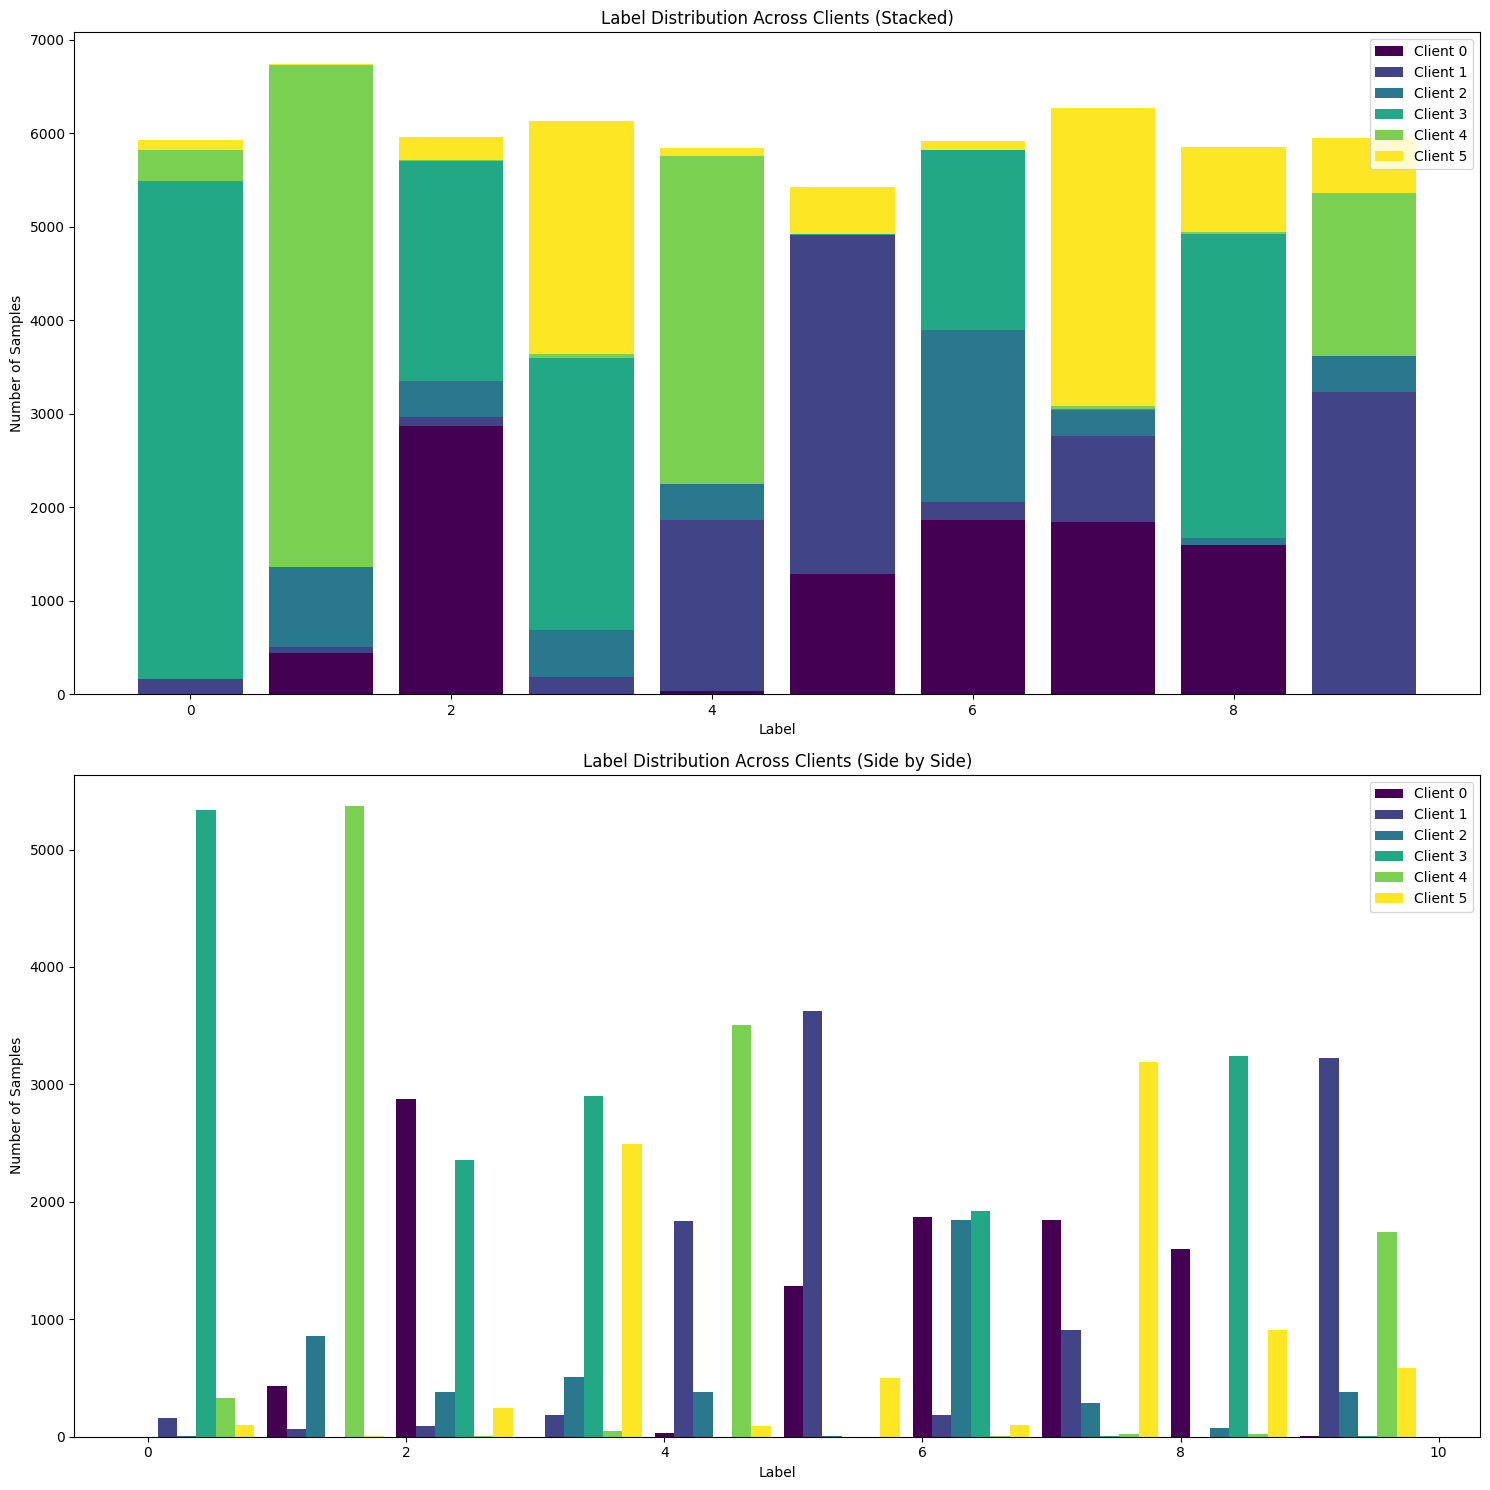

In [10]:
# Cell 5: Plot Data Distribution

def plot_label_distribution(client_datasets, dataset, num_classes=10):
   labels = torch.tensor(dataset.targets)
   fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

   # Calculate distributions
   client_distributions = []
   for client_data in client_datasets:
       client_labels = [labels[idx].item() for idx in client_data.indices]
       unique, counts = np.unique(client_labels, return_counts=True)
       dist = np.zeros(num_classes)
       for label, count in zip(unique, counts):
           dist[label] = count
       client_distributions.append(dist)
   client_distributions = np.array(client_distributions)

   # Stacked bar chart
   bottom = np.zeros(num_classes)
   colors = plt.cm.viridis(np.linspace(0, 1, len(client_datasets)))
   for i in range(len(client_datasets)):
       ax1.bar(range(num_classes), client_distributions[i], bottom=bottom,
               label=f'Client {i}', color=colors[i])
       bottom += client_distributions[i]
   ax1.set_xlabel('Label')
   ax1.set_ylabel('Number of Samples')
   ax1.set_title('Label Distribution Across Clients (Stacked)')
   ax1.legend()

   # Side-by-side bar chart
   width = 0.15
   x = np.arange(num_classes)
   for i in range(len(client_datasets)):
       ax2.bar(x + i*width, client_distributions[i], width,
               label=f'Client {i}', color=colors[i])
   ax2.set_xlabel('Label')
   ax2.set_ylabel('Number of Samples')
   ax2.set_title('Label Distribution Across Clients (Side by Side)')
   ax2.legend()

   plt.tight_layout()
   plt.show()

# Plot distributions
plot_label_distribution(client_datasets, trainset)

In [11]:
# Cell 4: Model Architecture
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128)
        )

        self.fc_out = nn.Linear(128, num_classes)
        self.prototype_layer = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        features = self.classifier(x)
        prototypes = self.prototype_layer(features)
        output = self.fc_out(features)
        return output, prototypes, features

In [12]:
# Cell 5: Training Functions
def train_client(model, train_loader, device, epochs=5):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output, prototypes, _ = model(data)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            running_loss += loss.item()

        acc = 100. * correct / total
        print(f'Epoch {epoch+1}: Loss: {running_loss/len(train_loader):.4f}, Accuracy: {acc:.2f}%')

    return model

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _, _ = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return 100. * correct / total

In [15]:
# Cell 6: Federation Functions
def aggregate_models(client_models):
    global_dict = client_models[0].state_dict()
    for key in global_dict.keys():
        # Convert to float before averaging
        tensors = [client_model.state_dict()[key].float() for client_model in client_models]
        global_dict[key] = torch.mean(torch.stack(tensors), dim=0).to(global_dict[key].dtype)
    return global_dict

def initialize_client_models(global_model, num_clients, device):
    return [copy.deepcopy(global_model).to(device) for _ in range(num_clients)]

In [16]:
# Cell 7: Main Training Loop (Modified)
num_clients = 6
num_rounds = 5
local_epochs = 5

# Initialize accuracy tracking
global_accuracies = []

# Create client datasets and loaders
client_datasets = create_non_iid_data(trainset, num_clients=num_clients)
train_loaders, test_loaders = create_data_loaders(client_datasets, testset)

# Initialize models
global_model = CNNModel().to(device)
client_models = initialize_client_models(global_model, num_clients, device)

# Training loop
for round_idx in range(num_rounds):
    print(f"\nRound {round_idx + 1}")

    # Train clients
    for i in range(num_clients):
        print(f"\nTraining Client {i+1}")
        client_models[i].load_state_dict(global_model.state_dict())
        client_models[i] = train_client(client_models[i], train_loaders[i], device, local_epochs)

    # Aggregate models
    global_dict = aggregate_models(client_models)
    global_model.load_state_dict(global_dict)

    # Evaluate global model
    round_acc = 0
    for i in range(num_clients):
        acc = evaluate_model(global_model, test_loaders[i], device)
        round_acc += acc
        print(f"Client {i+1} Test Accuracy: {acc:.2f}%")

    # Store average accuracy for this round
    global_accuracies.append(round_acc / num_clients)

<ipython-input-8-39e0b104c6eb>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(dataset.targets)



Round 1

Training Client 1
Epoch 1: Loss: 0.1971, Accuracy: 93.99%
Epoch 2: Loss: 0.1053, Accuracy: 96.75%
Epoch 3: Loss: 0.0779, Accuracy: 97.72%
Epoch 4: Loss: 0.0672, Accuracy: 97.80%
Epoch 5: Loss: 0.0600, Accuracy: 98.12%

Training Client 2
Epoch 1: Loss: 0.2918, Accuracy: 90.80%
Epoch 2: Loss: 0.1352, Accuracy: 95.56%
Epoch 3: Loss: 0.1048, Accuracy: 96.72%
Epoch 4: Loss: 0.0914, Accuracy: 97.07%
Epoch 5: Loss: 0.0682, Accuracy: 97.67%

Training Client 3
Epoch 1: Loss: 0.2028, Accuracy: 94.02%
Epoch 2: Loss: 0.0993, Accuracy: 96.98%
Epoch 3: Loss: 0.0786, Accuracy: 97.66%
Epoch 4: Loss: 0.0647, Accuracy: 97.95%
Epoch 5: Loss: 0.0552, Accuracy: 98.17%

Training Client 4
Epoch 1: Loss: 0.1556, Accuracy: 95.26%
Epoch 2: Loss: 0.0620, Accuracy: 98.12%
Epoch 3: Loss: 0.0600, Accuracy: 98.01%
Epoch 4: Loss: 0.0476, Accuracy: 98.54%
Epoch 5: Loss: 0.0413, Accuracy: 98.73%

Training Client 5
Epoch 1: Loss: 0.1606, Accuracy: 95.28%
Epoch 2: Loss: 0.0775, Accuracy: 97.50%
Epoch 3: Loss: 0


Final Results:
Initial Accuracy: 11.35%
Best Accuracy: 93.48%
Final Accuracy: 93.48%


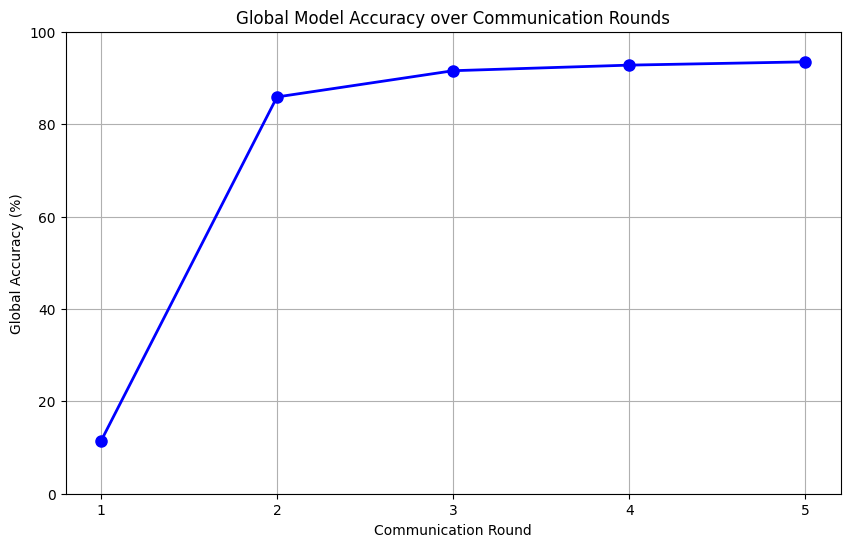

In [21]:
# Process accuracy data
global_accuracies = [11.35, 85.88, 91.56, 92.77, 93.48]  # From your results

# Create accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(global_accuracies) + 1), global_accuracies, 'b-o', linewidth=2, markersize=8)
plt.title('Global Model Accuracy over Communication Rounds')
plt.xlabel('Communication Round')
plt.ylabel('Global Accuracy (%)')
plt.grid(True)
plt.ylim(0, 100)  # Set y-axis from 0 to 100%
plt.xticks(range(1, len(global_accuracies) + 1))

print(f"\nFinal Results:")
print(f"Initial Accuracy: {global_accuracies[0]:.2f}%")
print(f"Best Accuracy: {max(global_accuracies):.2f}%")
print(f"Final Accuracy: {global_accuracies[-1]:.2f}%")

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(global_accuracies) + 1), global_accuracies, 'b-o', linewidth=2, markersize=8)
plt.title('Global Model Accuracy over Communication Rounds')
plt.xlabel('Communication Round')
plt.ylabel('Global Accuracy (%)')
plt.grid(True)
plt.ylim(0, 100)
plt.xticks(range(1, len(global_accuracies) + 1))
plt.show()

print(f"\nFinal Results:")
print(f"Initial Accuracy: {global_accuracies[0]:.2f}%")
print(f"Best Accuracy: {max(global_accuracies):.2f}%")
print(f"Final Accuracy: {global_accuracies[-1]:.2f}%")